## Configuration and imports

In [2]:
# basic configuration, put these lines at the top of each notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from joblib import dump, load
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, plot_confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, plot_roc_curve
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.exceptions import ConvergenceWarning
import shap

In [4]:
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams.update({'font.size': 22})
pd.options.display.max_columns = None
pd.set_option("display.precision", 2)
pd.options.display.max_rows = 100

import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Load credit card transaction data

In [5]:
DATA_PATH = "../data/ieee-credit-card-fraud/"

In [5]:
# load datasets
transaction_data = pd.read_csv(f'{DATA_PATH}train_transaction.csv')
identity_data = pd.read_csv(f'{DATA_PATH}train_identity.csv')

# join datasets
data = pd.merge(transaction_data, 
                identity_data, 
                on='TransactionID', 
                how='left')
data = data.drop(columns=['TransactionID'])

In [6]:
cat_feats = ['isFraud', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 
             'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 
             'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
             'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
             'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

In [7]:
for feat in cat_feats:
    data[feat] = data[feat].astype('category')

## Describe dataset

In [8]:
def print_shape(df):
    print(f'''Credit card transaction dataset: 
    - {df.shape[0]} rows (examples) 
    - {df.shape[1]} columns (attributes)''')
    return

def print_dtypes(df):
    dtypes = [df[feat].dtype.name for feat in df.columns]
    c = Counter(dtypes)
    type_counts = c.most_common()
    for count in type_counts:
        print(f'Dataset contains {count[1]} features of type {count[0]}.')
    return

In [9]:
print_shape(data)
print_dtypes(data)

Credit card transaction dataset: 
    - 590540 rows (examples) 
    - 433 columns (attributes)
Dataset contains 382 features of type float64.
Dataset contains 50 features of type category.
Dataset contains 1 features of type int64.


## Target variable distribution

In [10]:
print(data.isFraud.value_counts())
print(data.isFraud.value_counts(normalize=True))

0    569877
1     20663
Name: isFraud, dtype: int64
0    0.97
1    0.03
Name: isFraud, dtype: float64


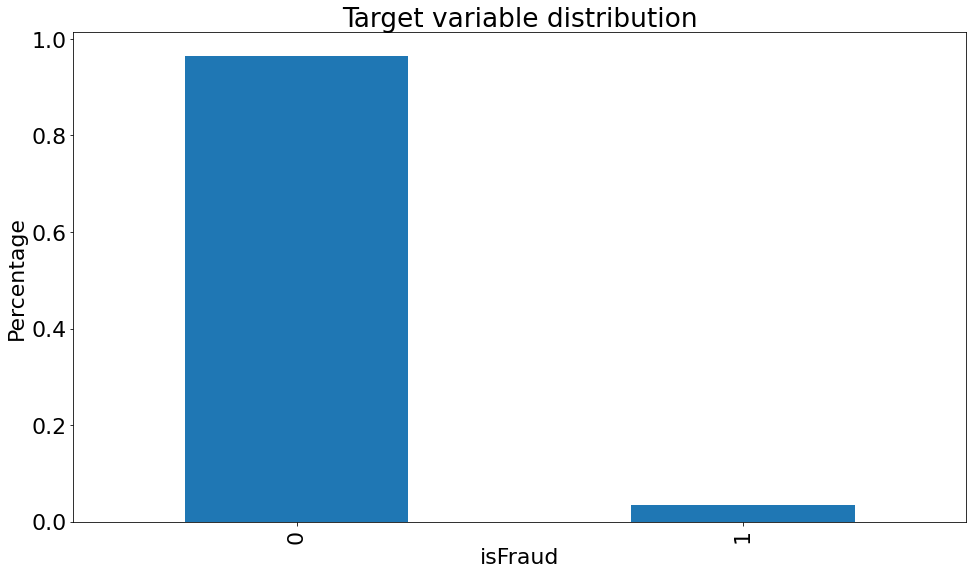

In [11]:
data.isFraud.value_counts(normalize=True).plot(kind='bar')
plt.title('Target variable distribution')
plt.ylabel('Percentage')
plt.xlabel('isFraud')
plt.show()

## Input variable distributions

In [12]:
data.TransactionAmt.describe()

count    590540.00
mean        135.03
std         239.16
min           0.25
25%          43.32
50%          68.77
75%         125.00
max       31937.39
Name: TransactionAmt, dtype: float64

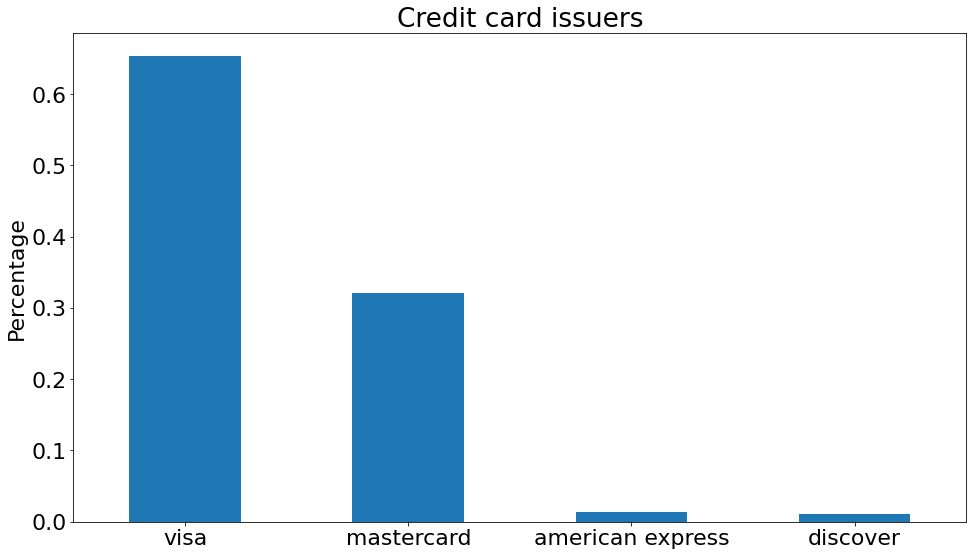

In [13]:
data.card4.value_counts(normalize=True).plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('Percentage')
plt.title('Credit card issuers')
plt.show()

## Attribute sampling

In [14]:
def remove_missing_vals(df, cutoff, axis=0):
    missing = df.isnull().sum(axis=axis).sort_values(ascending=False)
    missing_perc = missing / df.shape[axis]
    drop = missing_perc.loc[missing_perc > cutoff].index.to_list()
    result = df.drop(labels=drop, axis=(1 if axis == 0 else 0))
    return result

In [15]:
data = remove_missing_vals(data, 0.1)
print_shape(data)

Credit card transaction dataset: 
    - 590540 rows (examples) 
    - 111 columns (attributes)


## Record sampling

In [16]:
data = remove_missing_vals(data, 0.1, axis=1)
print_shape(data)

Credit card transaction dataset: 
    - 589099 rows (examples) 
    - 111 columns (attributes)


In [17]:
def mark_cat_feats(df, cat_feats):
    cats = list(set(df.columns) & set(cat_feats))
    for cat in cats:
        df[cat] = df[cat].astype('category')
    return df

In [18]:
data = mark_cat_feats(data, cat_feats)

## Imputation of missing values

In [19]:
def cont_cat_split(df, dep_var=None):
    cont_names, cat_names = [], []
    for label in df:
        if label == dep_var: continue
        if df[label].dtype == int or df[label].dtype == float: 
            cont_names.append(label)
        else: 
            cat_names.append(label)
    return cont_names, cat_names

def impute_missing_values(df, dep_var=None):
    cont_vars, cat_vars = cont_cat_split(df, dep_var=dep_var)
    cont_imp = SimpleImputer(missing_values=np.NaN, strategy="median")
    df[cont_vars] = cont_imp.fit_transform(df[cont_vars])
    #cat_imp = SimpleImputer(missing_values=np.NaN, strategy="most_frequent")
    #df[cat_vars] = cat_imp.fit_transform(df[cat_vars])
    return df

In [20]:
data = impute_missing_values(data, dep_var='isFraud')

In [21]:
data.isnull().sum().sum()

17877

In [22]:
data = mark_cat_feats(data, cat_feats)

## Decompose datetime variable

In [23]:
def make_day_feature(col, offset=0):
    days = col / (3600*24)        
    encoded_days = np.floor(days-1+offset) % 7
    return encoded_days

def make_hour_feature(col):
    hours = col / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

def decompose_datetime(data, dt_var, day_offset=0.58):
    data['day'] = make_day_feature(data[dt_var], offset=day_offset).astype('int64').astype('category')
    data['hour'] = make_hour_feature(data[dt_var]).astype('int64').astype('category')
    data = data.drop(columns=[dt_var])
    return data

In [24]:
data = decompose_datetime(data, 'TransactionDT')

## Rescale numerical variables

In [25]:
def rescale_cont_vars(data, log_transform=True, dep_var=None):
    cont_vars, _ = cont_cat_split(data, dep_var=dep_var)
    if log_transform:
        log_transformer = FunctionTransformer(
            func=np.log1p, 
            inverse_func=np.expm1, 
            validate=False)
        data[cont_vars] = log_transformer.fit_transform(data[cont_vars])
    scaler = MinMaxScaler()
    data[cont_vars] = scaler.fit_transform(data[cont_vars])
    return data

In [26]:
data = rescale_cont_vars(data, dep_var='isFraud')
data.TransactionAmt.describe()

count    589099.00
mean          0.41
std           0.09
min           0.00
25%           0.35
50%           0.40
75%           0.45
max           1.00
Name: TransactionAmt, dtype: float64

In [27]:
data = mark_cat_feats(data, cat_feats)

## Concatenate long-tail categories

In [28]:
def concat_long_tail(df, n=10, dep_var=None):
    _, cat_vars = cont_cat_split(df, dep_var=dep_var)
    for cat in cat_vars:
        col = df[cat]
        top_n_cats = list(col.value_counts().index[:n])
        mask = [False if row in top_n_cats else True for row in col]
        dtype = str(col.cat.categories.dtype)
        fill_val = ("other" if dtype == "object" else -1)
        col.cat.add_categories(fill_val, inplace=True)
        temp = col.mask(mask, other=fill_val)
        temp.cat.remove_unused_categories(inplace=True)
        df[cat] = temp
    return df

In [29]:
data = concat_long_tail(data, dep_var='isFraud')

In [30]:
data.card1.describe()

count     589099
unique        11
top           -1
freq      499452
Name: card1, dtype: int64

## One-hot encoding

In [31]:
def one_hot_encode(data, dep_var=None):
    _, cat_vars = cont_cat_split(data, dep_var=dep_var)
    one_hot_data = pd.get_dummies(data[cat_vars], prefix=cat_vars)
    data = data.drop(columns=cat_vars)
    return pd.concat([data, one_hot_data], axis=1)

In [32]:
data = one_hot_encode(data, dep_var='isFraud')

In [33]:
data[['card4_visa', 
      'card4_mastercard', 
      'card4_discover', 
      'card4_american express']].head()

,card4_visa,card4_mastercard,card4_discover,card4_american express
0,0,0,1,0
1,0,1,0,0
2,1,0,0,0
3,0,1,0,0
4,0,1,0,0


## Save feature engineering progress

In [34]:
data.shape

(589099, 180)

In [35]:
data.head()

,isFraud,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card1_2803,card1_6019,card1_7585,card1_7919,card1_9500,card1_12544,card1_12695,card1_15066,card1_15885,card1_17188,card1_-1,card2_111.0,card2_170.0,card2_194.0,card2_321.0,card2_360.0,card2_490.0,card2_514.0,card2_545.0,card2_555.0,card2_583.0,card2_-1.0,card3_102.0,card3_106.0,card3_117.0,card3_119.0,card3_143.0,card3_144.0,card3_146.0,card3_147.0,card3_150.0,card3_185.0,card3_-1.0,card4_american express,card4_discover,card4_mastercard,card4_visa,card4_other,card5_102.0,card5_117.0,card5_126.0,card5_137.0,card5_138.0,card5_166.0,card5_195.0,card5_219.0,card5_224.0,card5_226.0,card5_-1.0,card6_charge card,card6_credit,card6_debit,card6_debit or credit,card6_other,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_0,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_-1
0,0,0.40,0.08,0.08,0.0,0.0,0.0,0.09,0.0,0.00,0.13,0.00,0.14,0.0,0.09,0.1,0.42,0.0,0.10,0.00,0.0,0.00,0.00,0.0,0.10,0.00,0.0,0.0,0.0,1.0,0.33,0.33,0.33,0.3,0.3,0.3,0.36,0.36,0.36,0.5,0.5,0.5,0.5,0.5,0.5,0.26,0.26,0.26,0.00,0.40,0.00,0.0,0.00,0.00,0.00,0.40,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.2,0.16,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.40,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.40,0.00,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.31,0.08,0.08,0.0,0.0,0.0,0.09,0.0,0.00,0.00,0.00,0.09,0.0,0.09,0.1,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,1.0,0.33,0.33,0.33,0.3,0.3,0.3,0.36,0.36,0.36,0.5,0.5,0.5,0.5,0.5,0.5,0.26,0.26,0.26,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.2,0.16,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.38,0.08,0.08,0.0,0.0,0.0,0.09,0.0,0.00,0.13,0.00,0.09,0.0,0.09,0.1,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,1.0,0.33,0.33,0.33,0.3,0.3,0.3,0.36,0.36,0.36,0.5,0.5,0.5,0.5,0.5,0.5,0.26,0.26,0.26,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.2,0.16,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.37,0.13,0.21,0.0,0.0,0.0,0.21,0.0,0.00,0.13,0.00,0.09,0.0,0.41,0.1,0.73,0.1,0.54,0.49,0.0,0.53,0.48,0.1,0.51,0.47,0.0,0.0,0.0,1.0,0.33,0.33,0.33,0.3,0.3,0.3,0.36,0.36,0.36,0.5,0.5,0.5,0.5,0.5,0.5,0.26,0.26,0.26,0.33,0.62,0.57,0.0,0.54,0.45,0.34,0.61,0.58,0.0,0.0,0.0,0.1,0.49,0.0,0.0,0.00,0.0,0.53,0.0,0.46,0.0,0.0,0.0,0.0,0.0,0.1,0.51,0.47,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.34,0.63,0.59,0.0,0.54,0.0,0.45,0.0,0.0,0.0,0.34,0.61,0.58,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.37,0.08,0.08,0.0,0.0,0.0,0.09,0.0,0.09,0.00,0.09,0.09,0.0,0.09,0.1,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,1.0,0.33,0.33,0.33,0.3,0.3,0.3,0.36,0.36,0.3

In [36]:
data.to_csv(f'{DATA_PATH}credict_card_transaction_preprocessed.csv', index=False)

## Prepare dataset for model training

In [59]:
# split training and testing data
train, test = train_test_split(data, test_size=10000, random_state=47)
print(train.shape)
print(test.shape)

(579099, 180)
(10000, 180)


In [60]:
print(train.isFraud.value_counts(normalize=True))
print(test.isFraud.value_counts(normalize=True))

0    0.97
1    0.03
Name: isFraud, dtype: float64
0    0.96
1    0.04
Name: isFraud, dtype: float64


In [61]:
# rebalance dataset
fraud = train[train.isFraud == 1]
valid = train[train.isFraud == 0]
valid = resample(valid, 
                 replace=False, 
                 n_samples=len(fraud)*4, 
                 random_state=47)
train = pd.concat([fraud, valid])

In [8]:
# separate input and target variables
def split_data(df, dep_var):
    return df.drop(columns=[dep_var]), df[dep_var]

In [63]:
X_train, y_train = split_data(train, 'isFraud')
X_test, y_test = split_data(test, 'isFraud')

In [64]:
print(X_train.shape)
print(y_train.shape)

(101195, 179)
(101195,)


In [65]:
y_test.value_counts(normalize=True)

0    0.96
1    0.04
Name: isFraud, dtype: float64

In [9]:
def eval_model(model, X, y):
    pred = model.predict_proba(X)
    if pred.shape[1] == 1:
        pred = np.hstack((pred, np.expand_dims(np.zeros(len(pred)), -1)))
    return roc_auc_score(y, pred[:, 1])

## Train logistic regression model

In [67]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(f'Performance on training set: {eval_model(lr, X_train, y_train)}')
print(f'Performance on test set: {eval_model(lr, X_test, y_test)}')

Performance on training set: 0.8704095488723481
Performance on test set: 0.8860163808793946


## Train random forest model

In [68]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(f'Performance on training set: {eval_model(rf, X_train, y_train)}')
print(f'Performance on test set: {eval_model(rf, X_test, y_test)}')

Performance on training set: 0.9999620606068368
Performance on test set: 0.9294878922447414


## Train gradient boosting model

In [70]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
print(f'Performance on training set: {eval_model(gb, X_train, y_train)}')
print(f'Performance on test set: {eval_model(gb, X_test, y_test)}')

Performance on training set: 0.8839086361089873
Performance on test set: 0.9057705992637499


## Hyperparameter tuning with cross-validation

In [79]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 50]
}
rf_cv = RandomForestClassifier()

cv = GridSearchCV(rf_cv, param_grid)
cv.fit(X_train, y_train)

cv_est = cv.best_estimator_
print(f'Performance on training set: {eval_model(cv_est, X_train, y_train)}')
print(f'Performance on test set: {eval_model(cv_est, X_test, y_test)}')

Performance on training set: 0.9998957264044636
Performance on test set: 0.9318072053517259


In [81]:
dump(cv_est, 'rf_cv_best_estimator.joblib')

['rf_cv_best_estimator.joblib']

In [83]:
cv_est.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [85]:
model = cv_est

## Ensembling with VotingClassifier

In [84]:
lr_ens = LogisticRegression()
rf_ens = RandomForestClassifier()
gb_ens = GradientBoostingClassifier()

ens = VotingClassifier([('lr', lr_ens), ('rf', rf_ens), ('gb', gb_ens)], 
                       voting='soft')
ens.fit(X_train, y_train)
print(f'Performance on training set: {eval_model(ens, X_train, y_train)}')
print(f'Performance on test set: {eval_model(ens, X_test, y_test)}')

Performance on training set: 0.9847445451382878
Performance on test set: 0.9259119875558233


## Confusion matrix and metrics

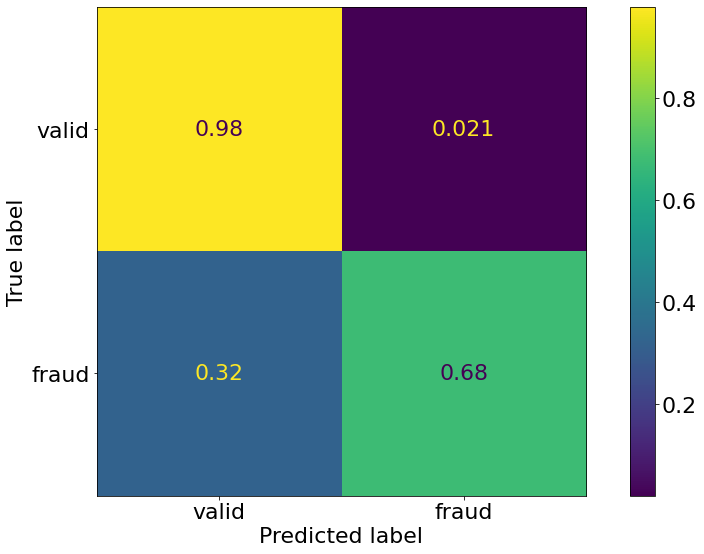

In [91]:
plot_confusion_matrix(model, 
                      X_test, 
                      y_test,
                      normalize='true',
                      display_labels=['valid', 'fraud'])
plt.show()

In [93]:
print(f'Precision: {precision_score(y_test, model.predict(X_test))}')
print(f'Recall: {recall_score(y_test, model.predict(X_test))}')
print(f'F1 score: {f1_score(y_test, model.predict(X_test))}')
print(f'Accuracy score: {accuracy_score(y_test, model.predict(X_test))}')

Precision: 0.5454545454545454
Recall: 0.6758241758241759
F1 score: 0.603680981595092
Accuracy score: 0.9677


## Plot ROC curve

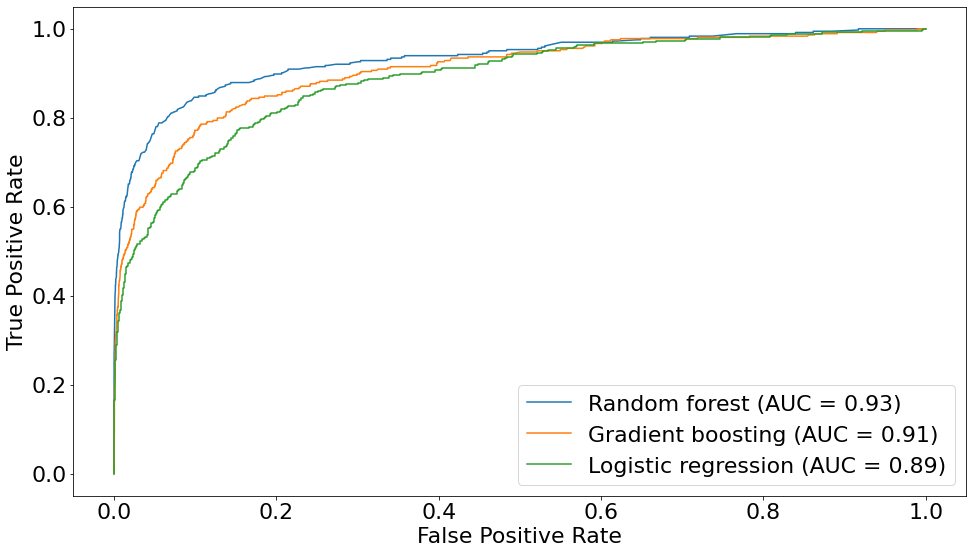

In [98]:
fig, ax = plt.subplots()
plot_roc_curve(model, X_test, y_test, name='Random forest', ax=ax)
plot_roc_curve(gb, X_test, y_test, name='Gradient boosting', ax=ax)
plot_roc_curve(lr, X_test, y_test, name='Logistic regression', ax=ax)
plt.plot(0.675, )
plt.show()

## Prepare model interpretation

In [6]:
data = pd.read_csv(f'{DATA_PATH}credict_card_transaction_preprocessed.csv')

In [7]:
train, test = train_test_split(data, test_size=10000, random_state=47)
fraud = train[train.isFraud == 1]
valid = train[train.isFraud == 0]
valid = resample(valid, 
                 replace=False, 
                 n_samples=len(fraud)*4, 
                 random_state=47)
train = pd.concat([fraud, valid])

In [10]:
X_train, y_train = split_data(train, 'isFraud')
X_test, y_test = split_data(test, 'isFraud')

In [11]:
model = load('rf_cv_best_estimator.joblib')

In [13]:
sample = test.sample(n=100, random_state=47)
X_sample, y_sample = split_data(sample, 'isFraud')
print(y_sample.value_counts())

0    94
1     6
Name: isFraud, dtype: int64


## Global interpretability with SHAP

In [ ]:
explainer = shap.TreeExplainer(model)
shap_value = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_sample)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
